We briefly discussed how to recognize whether a deep learning model is overfitting. We can compare the model's training accuracy or loss curve to that of its validation accuracy or loss curve, respectively, to gauge the model's performance.

![](https://s3.amazonaws.com/dq-content/781/1.1-m781.png)

Remedying overfitting is crucial for any model we build. We can't have a model perform poorly on unseen data, as that could have serious ramifications. For the use-case of developing a model that needs to accurately classify whether the leaf of a bean plant is diseased or not, we can't have a model that misclassifies any new leaves we ask it to label. It could negatively impact farmers and their crop yields.

Regularization refers to a set of techniques used to prevent overfitting during the training process. In this file, we'll learn about different regularization approaches that could help tackle overfitting.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, initializers
import matplotlib.pyplot as plt

In [2]:
train_set = tf.keras.utils.image_dataset_from_directory(
    directory='beans/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(227, 227))

validation_set = tf.keras.utils.image_dataset_from_directory(
    directory='beans/validation/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(227, 227))

test_set = tf.keras.utils.image_dataset_from_directory(
    directory='beans/test/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(227, 227))

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.


In [3]:
train_imgs = train_set.map(lambda imgs, labels: imgs)
normalization_layer = layers.Normalization(axis=-1)
normalization_layer.adapt(train_imgs)

train_set_normalized = train_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))
validation_set_normalized = validation_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))
test_set_normalized = test_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))

In [6]:
model = models.Sequential()

model.add(layers.Input(shape = (227, 227, 3)))
model.add(layers.Conv2D(filters=64, kernel_size=5, strides=2, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=3, strides=2))

model.add(layers.Conv2D(filters=64, kernel_size=5, strides=2, padding="same", activation='relu'))
model.add(layers.MaxPooling2D(pool_size=3, strides=1))

model.add(layers.Conv2D(filters=128, kernel_size=5, strides=2, padding="same", activation='relu'))
model.add(layers.MaxPooling2D(pool_size=3, strides=1))

model.add(layers.Flatten())

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(3))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 112, 112, 64)        │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 55, 55, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 13, 13, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 15488)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │      15,860,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,225,667 (65.71 MB)

 Trainable params: 17,225,667 (65.71 MB)

 Non-trainable params: 0 (0.00 B)

The model's summary showed that our model has around 18 million parameters. In comparison, the AlexNet model we built in the last file had almost 60 million parameters!

The number of training parameters can indicate whether the model will overfit, especially on smaller datasets like ours. A higher number of parameters increases the risk of overfitting, but this isn't always the case. Other factors, such as the optimizer, regularization, and our choices for hyperparameters — learning rate, batch size, number of epochs — can still affect the model's performance as well.

Let's try training our model to see if it's overfitting.

In [7]:
opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

history = model.fit(train_set_normalized, epochs=25, validation_data=validation_set_normalized)

Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 586ms/step - accuracy: 0.3248 - loss: 2.0233 - val_accuracy: 0.5188 - val_loss: 1.0021
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 539ms/step - accuracy: 0.5359 - loss: 0.9747 - val_accuracy: 0.6692 - val_loss: 0.8857
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 538ms/step - accuracy: 0.6391 - loss: 0.8716 - val_accuracy: 0.7143 - val_loss: 0.6612
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 540ms/step - accuracy: 0.6973 - loss: 0.6625 - val_accuracy: 0.7293 - val_loss: 0.5758
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 542ms/step - accuracy: 0.7589 - loss: 0.5346 - val_accuracy: 0.7669 - val_loss: 0.5596
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 540ms/step - accuracy: 0.7970 - loss: 0.5052 - val_accuracy: 0.7594 - val_loss: 0.4820
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 542ms/step - accuracy: 0.8146 - loss: 0.4413 - val_accuracy: 0.7820 - val_loss: 0.5054
Epoch 8/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 543ms/step - accuracy: 0.8331 - loss: 0.3859 - val_accu

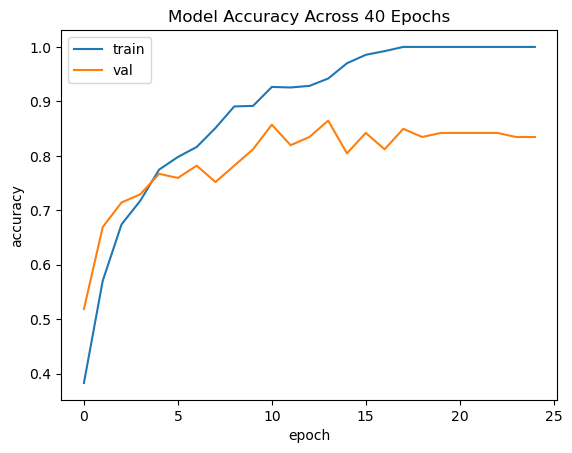

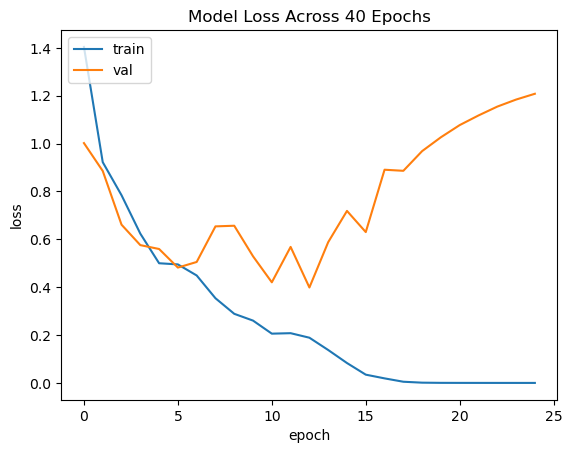

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Across 40 Epochs')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Across 40 Epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [10]:
test_loss, test_acc = model.evaluate(test_set_normalized)
print(f"Test set accuracy: {test_acc}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9042 - loss: 0.7644
Test set accuracy: 0.875


###  Early Stopping

Our model's training accuracy is significantly higher than its validation accuracy, as seen in the plot above. After a certain number of epochs, the gap between the two continues to widen. The model is indeed overfitting.

Our model is not overly complicated, but even with only `25` epochs and a small dataset, it can take several minutes to finish training. For larger models and with more data, we may need to train for much longer to observe a trend. It would be a waste of resources to train a model for 100 epochs, only to find out it started to overfit after 60, for example.

What if we only trained our model up to the point where the gap between training and validation accuracy starts to widen? To accomplish this, we could set a criterion for when the model should stop training. For instance, we could define a condition that the model should stop training if the validation accuracy begins to decrease. With this criterion in place, we could stop the model's training as soon as it starts to overfit — or before.

This technique is known as **early stopping**.

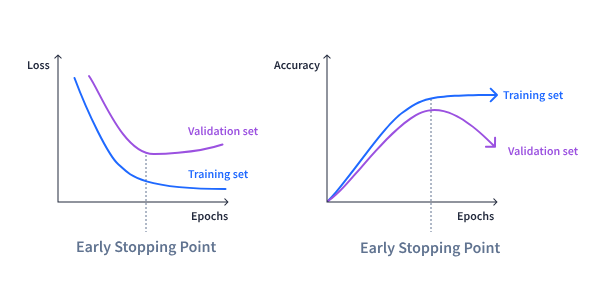

In Keras, we can create a [`callback` object](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) that we can define and pass to our `model.fit()` method. A callback is an object that can perform actions at different stages of training. For example, as we'll learn below, the early stopping callback can stop a model's training if the validation loss stops decreasing.

For implementing early stopping, we can use the [`EarlyStopping` class](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) as follows:

In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max')

Where,

-   `monitor` is the quantity we want to monitor, such as the validation accuracy. The History object that `model.fit()` returns provides us with a list of the possible quantities we can choose to monitor: `['loss', 'accuracy', 'val_loss', 'val_accuracy']`.
    
-   `patience` is the number of epochs after which training will stop if the quantity being monitored has not improved. In the example above, training will stop if `val_accuracy` has not improved over the last `5` consecutive epochs.
    
-   `mode` can take on one of three possible values:
    
    -   `min`: The training will stop if the monitored quantity, such as the validation loss, has stopped decreasing.
    -   `max`: The training will stop if the monitored quantity, such as the validation accuracy, has stopped increasing.
    -   `auto`: Keras automatically infers the mode depending on the monitored quanity.

The class has other parameters as well. You're encouraged to check out the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) to understand their use cases.

To use early stopping when training a model, we pass the above `callback` object to our call to `model.fit()`:

In [13]:
history = model.fit(train_set_normalized, epochs=25, 
                    validation_data=validation_set_normalized, 
                    callbacks=[callback])

Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 547ms/step - accuracy: 1.0000 - loss: 3.7254e-05 - val_accuracy: 0.8346 - val_loss: 1.2293
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 550ms/step - accuracy: 1.0000 - loss: 2.9557e-05 - val_accuracy: 0.8346 - val_loss: 1.2491
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 599ms/step - accuracy: 1.0000 - loss: 2.4660e-05 - val_accuracy: 0.8346 - val_loss: 1.2686
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 542ms/step - accuracy: 1.0000 - loss: 1.3654e-05 - val_accuracy: 0.8346 - val_loss: 1.2832
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 573ms/step - accuracy: 1.0000 - loss: 1.3509e-05 - val_accuracy: 0.8271 - val_loss: 1.3008
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 566ms/step - accuracy: 1.0000 - loss: 1.0328e-05 - val_accuracy: 0.8346 - val_loss: 1.3120


In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

model = models.Sequential()

model.add(layers.Input(shape = (227, 227, 3)))

model.add(layers.Conv2D(filters=64, kernel_size=5, strides=2, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=3, strides=2))

model.add(layers.Conv2D(filters=64, kernel_size=5, strides=2, padding="same", activation='relu'))
model.add(layers.MaxPooling2D(pool_size=3, strides=1))

model.add(layers.Conv2D(filters=128, kernel_size=5, strides=2, padding="same", activation='relu'))
model.add(layers.MaxPooling2D(pool_size=3, strides=1))
model.add(layers.Flatten())

model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(3))

opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

history = model.fit(train_set_normalized, epochs=25, validation_data=validation_set_normalized, callbacks=[callback])

C:\Users\CGDC\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 752ms/step - accuracy: 0.3446 - loss: 3.8153 - val_accuracy: 0.5038 - val_loss: 1.0432
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 746ms/step - accuracy: 0.4750 - loss: 1.0202 - val_accuracy: 0.4812 - val_loss: 0.9943
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 734ms/step - accuracy: 0.5153 - loss: 0.9316 - val_accuracy: 0.5113 - val_loss: 0.9418
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 743ms/step - accuracy: 0.5664 - loss: 0.8799 - val_accuracy: 0.5414 - val_loss: 0.8426
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 753ms/step - accuracy: 0.5819 - loss: 0.8370 - val_accuracy: 0.6015 - val_loss: 0.8101
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 733ms/step - accuracy: 0.6619 - loss: 0.7487 - val_accuracy: 0.6015 - val_loss: 0.8301
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 744ms/step - accuracy: 0.6703 - loss: 0.7154 - val_accuracy: 0.6316 - val_loss: 0.7515
Epoch 8/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 748ms/step - accuracy: 0.7165 - loss: 0.6678 - val_accu

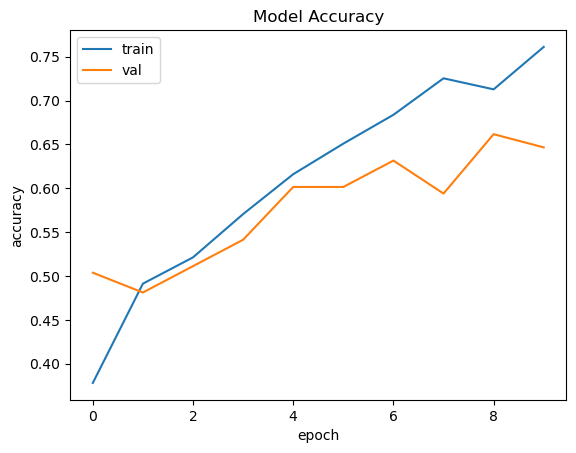

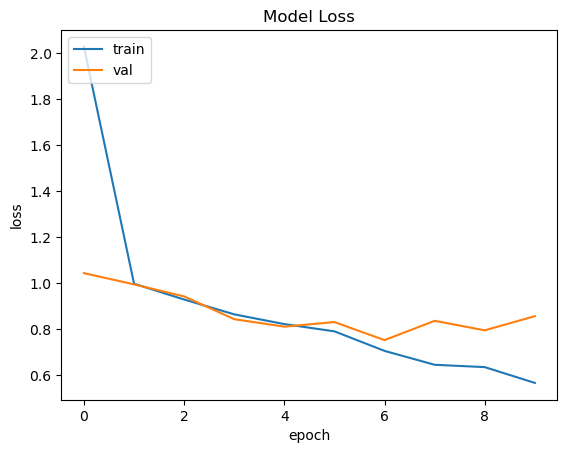

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.7625 - loss: 0.5905
Test set accuracy: 0.765625


In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

test_loss, test_acc = model.evaluate(test_set_normalized)
print(f"Test set accuracy: {test_acc}")

As desired, our model didn't train for the entire `25` epochs. It stopped training when the validation loss stopped decreasing. Here's what it looks like:

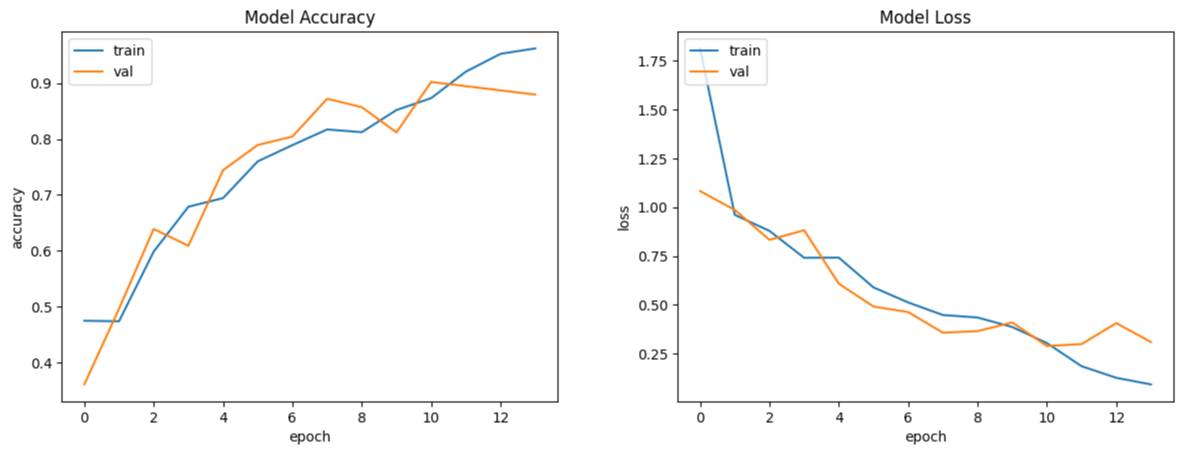

Early stopping can be a useful regularization approach. However, since we're not training our model for many epochs, we'll explore other regularization approaches without using early stopping.

### Dropout

In the previous file, we learned about dropout. It's a regularization technique in which randomly selected output units of a layer are set to zero during training. We specify a dropout rate, a value between `0` and `1`, which determines the fraction of units that are dropped. For example, a rate of `0.5` would result in `50%` of the units in that layer being set to zero.

A dropout layer with a rate of `0.5` has been applied to the hidden layer of the neural network shown below. During each training iteration, this layer will randomly drop half of the nodes. This means that not all nodes contribute to the model's learning at each step, effectively training a smaller network and reducing the risk of overfitting.

![](https://s3.amazonaws.com/dq-content/781/m781-4.1.gif)

Although the animation shows how dropout works on a fully-connected layer, the concept works similarly with convolutional layers. In Keras, a [dropout layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) can be defined as follows:

`tf.keras.layers.Dropout(rate)`


`rate` is the dropout rate, a value between `0` and `1`. By design, dropout is only applied during training. During the evaluation step, Keras automatically sets the `rate` to `1` to ensure that all neurons contribute to the evaluation. Dropping random neurons during evaluation would not improve the model's performance.

The dropout rate is a hyperparameter. Usually, a value of `0.5` to `0.8` is selected for fully connected layers. For convolutional layers, some [research](http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf) suggests that smaller rates — such as `0.1` to `0.2`— are better. It's better to add one dropout layer at a time, observe its impact, then adjust accordingly. For our model, we'll add dropout to each layer.

Usually when we add one or more dropout layers to a network, we want to allow it to train for longer to compensate for the dropped out nodes. However, for now, we'll only train our model for `25` epochs to observe if the dropout layers have had a regularization effect.

In [16]:
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=5, strides=2, activation='relu', input_shape=(227, 227, 3)))
model.add(layers.MaxPooling2D(pool_size=3, strides=2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=64, kernel_size=5, strides=2, padding="same", activation='relu'))
model.add(layers.MaxPooling2D(pool_size=3, strides=1))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=128, kernel_size=5, strides=2, padding="same", activation='relu'))
model.add(layers.MaxPooling2D(pool_size=3, strides=1))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())

model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(3))

opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

history = model.fit(train_set_normalized, epochs=25, validation_data=validation_set_normalized)

Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 848ms/step - accuracy: 0.3695 - loss: 3.1675 - val_accuracy: 0.5940 - val_loss: 0.9476
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 806ms/step - accuracy: 0.4034 - loss: 1.1036 - val_accuracy: 0.5940 - val_loss: 0.9276
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 830ms/step - accuracy: 0.5314 - loss: 0.9926 - val_accuracy: 0.6541 - val_loss: 0.7758
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 779ms/step - accuracy: 0.6018 - loss: 0.8923 - val_accuracy: 0.5338 - val_loss: 0.9278
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 795ms/step - accuracy: 0.6471 - loss: 0.7508 - val_accuracy: 0.6692 - val_loss: 0.7293
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 787ms/step - accuracy: 0.7143 - loss: 0.6996 - val_accuracy: 0.7143 - val_loss: 0.6527
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 777ms/step - accuracy: 0.7259 - loss: 0.6242 - val_accuracy: 0.7820 - val_loss: 0.6389
Epoch 8/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 790ms/step - accuracy: 0.7840 - loss: 0.5400 - val_accu

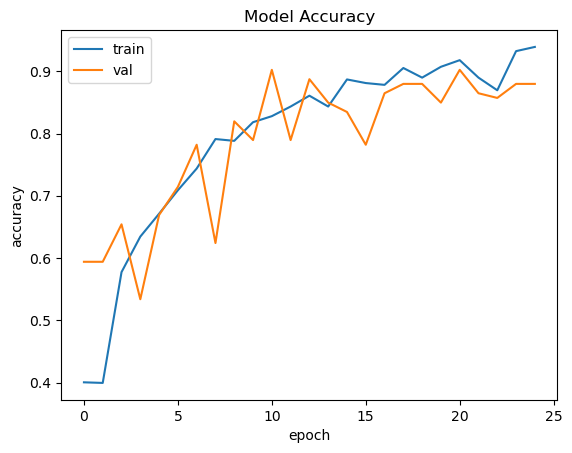

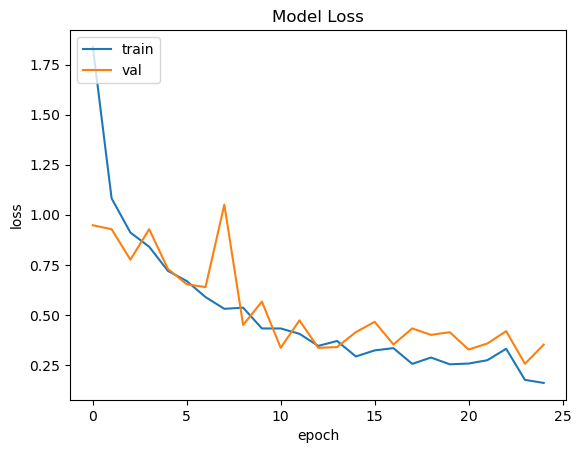

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8750 - loss: 0.5516
Test set accuracy: 0.859375


In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

test_loss, test_acc = model.evaluate(test_set_normalized)
print(f"Test set accuracy: {test_acc}")

After incorporating dropout layers, our trained model no longer overfitted!

![](https://s3.amazonaws.com/dq-content/781/5.0-m781.png)

Notice that the accuracy curves don't quite reach a plateau at `25` epochs, so we could've trained the model for longer to see if we could've achieved even better results.

### Batch Normalization

In a previous file, we discussed the importance of normalizing or standardizing our input data. What if we also normalized the activations of the layers in our model?

This is what batch normalization does. During training, a batch normalization layer calculates the mean and variance of the current batch of data. It then uses these values to normalize the output of the layer to which it's applied. This normalization of the activations of the layer has a regularizing effect.

We can apply a batch normalization layer as well as a dropout layer, but we don't *necessarily* need both. Batch normalization shouldn't be used as a replacement for normalizing the input data. Therefore, we'll continue to use normalized datasets in our implementation.

In Keras, we can define a [batch normalization layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) as follows:

`tf.keras.layers.BatchNormalization()`

Let's see how our model performs if we use batch normalization layers instead of using dropout layers.

In [18]:
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=5, strides=2, activation='relu',
                        input_shape=(227, 227, 3)))
model.add(layers.MaxPooling2D(pool_size=3, strides=2))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(filters=64, kernel_size=5, strides=2, padding="same", activation='relu'))
model.add(layers.MaxPooling2D(pool_size=3, strides=1))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(filters=128, kernel_size=5, strides=2, padding="same", activation='relu'))
model.add(layers.MaxPooling2D(pool_size=3, strides=1))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())

model.add(layers.Dense(2048, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(3))

opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

history = model.fit(train_set_normalized, epochs=25, validation_data=validation_set_normalized)

Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 758ms/step - accuracy: 0.5562 - loss: 2.2587 - val_accuracy: 0.4436 - val_loss: 8.3689
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 774ms/step - accuracy: 0.7554 - loss: 0.6402 - val_accuracy: 0.7143 - val_loss: 1.4450
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 841ms/step - accuracy: 0.7624 - loss: 0.6061 - val_accuracy: 0.6917 - val_loss: 0.9561
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 777ms/step - accuracy: 0.7914 - loss: 0.4870 - val_accuracy: 0.7820 - val_loss: 0.5570
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 754ms/step - accuracy: 0.8428 - loss: 0.4408 - val_accuracy: 0.7820 - val_loss: 0.5567
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 759ms/step - accuracy: 0.8319 - loss: 0.4321 - val_accuracy: 0.7895 - val_loss: 0.6421
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 801ms/step - accuracy: 0.8838 - loss: 0.3278 - val_accuracy: 0.7368 - val_loss: 0.8213
Epoch 8/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 793ms/step - accuracy: 0.8850 - loss: 0.3103 - val_accu

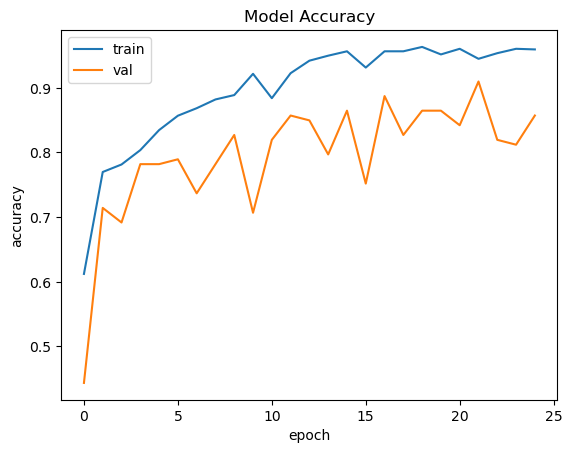

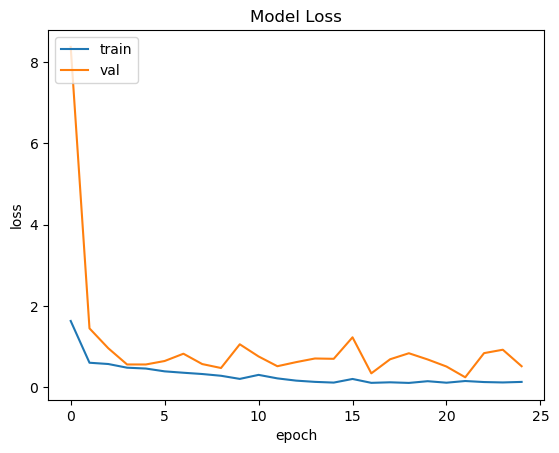

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8729 - loss: 0.4221
Test set accuracy: 0.84375


In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

test_loss, test_acc = model.evaluate(test_set_normalized)
print(f"Test set accuracy: {test_acc}")

### Batch Normalization II

Our model's performance on the validation set didn't significantly improve after adding the batch normalization layers. It appears to be performing well on the training set, however.

![](https://s3.amazonaws.com/dq-content/781/6.0-m781.png)

The reason for the poor performance is because of the difference between how batch normalization layers work during training and at the time of evaluating the validation set. During training, batch normalization uses the mean and variance of the current batch of data to normalize the outputs, whereas, during validation, batch normalization uses a running mean and variance to normalize the outputs.

During training, the layer keeps track of a running mean and a running variance. It calculates the moving average of the mean and variance of each batch across the entire dataset using the following equations:

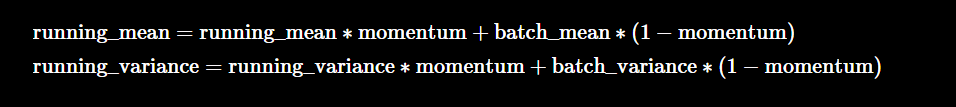

After the model trains on a batch of data, the running mean and variance are updated according to the equations above. The momentum factor determines how much the current batch affects the running mean and variance values.

  

\-   If momentum was zero, the running mean would be the same as the mean of the last batch of data.

\-   If momentum was one, the running mean would be the same as the mean of the first batch of data.

  

Either value could result in a biased model, so we need to select an appropriate value for the momentum, between \`0\` and \`1\`. The running mean and variance values are then used to normalize the validation or test sets. Selecting an appropriate value for the momentum of a batch normalization layer can impact the model's performance on those two sets. It's another hyperparameter we can tune, although a momentum of \`0.9\` often improves results.

  

Let's set the value for the \`momentum\` parameter in our batch normalization layers, and add dropout layers again to see if the model's performance improves on the validation set.

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=5, strides=2, activation='relu', input_shape=(227, 227, 3)))
model.add(layers.MaxPooling2D(pool_size=3, strides=2))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=64, kernel_size=5, strides=2, padding="same", activation='relu'))
model.add(layers.MaxPooling2D(pool_size=3, strides=1))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=128, kernel_size=5, strides=2, padding="same", activation='relu'))
model.add(layers.MaxPooling2D(pool_size=3, strides=1))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())

model.add(layers.Dense(2048, activation='relu'))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(3))

opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

history = model.fit(train_set_normalized, epochs=25, validation_data=validation_set_normalized)

Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 788ms/step - accuracy: 0.5241 - loss: 1.9886 - val_accuracy: 0.6165 - val_loss: 1.3926
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 768ms/step - accuracy: 0.6650 - loss: 0.9978 - val_accuracy: 0.7218 - val_loss: 0.8497
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 770ms/step - accuracy: 0.7523 - loss: 0.7918 - val_accuracy: 0.7895 - val_loss: 0.5131
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 761ms/step - accuracy: 0.7785 - loss: 0.7115 - val_accuracy: 0.7820 - val_loss: 0.6503
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 756ms/step - accuracy: 0.8086 - loss: 0.5795 - val_accuracy: 0.7669 - val_loss: 0.5807
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 776ms/step - accuracy: 0.8184 - loss: 0.5425 - val_accuracy: 0.8722 - val_loss: 0.3268
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 774ms/step - accuracy: 0.8223 - loss: 0.5182 - val_accuracy: 0.8421 - val_loss: 0.4470
Epoch 8/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 766ms/step - accuracy: 0.8297 - loss: 0.4560 - val_accu

In [4]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

test_loss, test_acc = model.evaluate(test_set_normalized)
print(f"Test set accuracy: {test_acc}")

### Data Augmentation


![](https://s3.amazonaws.com/dq-content/781/7.0v2-m-781.png)

Our model's performance improved on the validation set! However, there's still some overfitting happening. We *could* modify the model architecture and tune various hyperparameters to get even better results. But before we invest any time into that, there's something else we should consider first.

### Augmenting the Data

Given the small size of our datasets, a lot our experimentation could struggle to yield better results. This brings us to the next type of regularization: **data augmentation**.

Our goal is to generalize our model, so having more images is beneficial. However, simply creating copies of the same image won't help our model learn anything new. To ensure our model doesn't overfit, it's important to have enough variation across the images in the dataset.

If collecting more images isn't feasible, we can transform or augment the existing images to introduce variations. For example, we could take one of the images of the leaves in our dataset and flip it horizontally or vertically.

In Keras, we can add data augmentation layers to our model. These layers randomly transform images in each batch for each training step. This helps reduce the chance of overfitting, as the model sees different variations of the same image for each training step.

To flip the images in the dataset, we could add the [`RandomFlip` layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip) to our model:

`tf.keras.layers.RandomFlip(mode="horizontal")`

This is what the transformation would look like, if we flipped the image horizontally or vertically:

![](https://s3.amazonaws.com/dq-content/781/augmentation_flip.png)

We could also rotate the images by adding the [`RandomRotation` layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation):

`tf.keras.layers.RandomRotation(factor=0.2)`

![](https://s3.amazonaws.com/dq-content/781/augmentation_rotation.png)

The image was rotated by a random amount in the range `[-20% * 2pi, 20% * 2pi]`, where the `20%` is determined by the value we set for the `factor` argument. `2pi` radians is equivalent to `360` degrees, so the image was rotated by a random angle between `-72` to `72` degrees.

We could even crop the image to a specific height and width using the [`RandomCrop` layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomCrop):

`tf.keras.layers.RandomCrop(height=256, width=256)`

![](https://s3.amazonaws.com/dq-content/781/augmentation_cropped.png)

### Selecting Augmentations

We can see a potential limitation of certain transformations above. Cropping the image may cause us to lose out on relevant information, which could make it more difficult for our model to learn effectively.

We must be mindful of which augmentations to choose, depending on our dataset. Cropping our leaves is likely not a good option, as we saw above. If our dataset consisted of handwritten numbers, flipping the numbers would not be beneficial, as our model wouldn't be tested on a flipped 3, for example.

Keras offers many [options](https://www.tensorflow.org/guide/keras/preprocessing_layers#image_data_augmentation) for data augmentation that we recommend you explore. We'll add a couple of data augmentations to our model and evaluate it on the test set. Note that we aren't including any other regularization method for this next code.

In [5]:
model = models.Sequential()
model.add(layers.RandomFlip("horizontal_and_vertical"))
model.add(layers.RandomRotation(0.5))

model.add(layers.Conv2D(filters=64, kernel_size=5, strides=2, activation='relu', input_shape=(227, 227, 3)))
model.add(layers.MaxPooling2D(pool_size=3, strides=2))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=64, kernel_size=5, strides=2, padding="same", activation='relu'))
model.add(layers.MaxPooling2D(pool_size=3, strides=1))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=128, kernel_size=5, strides=2, padding="same", activation='relu'))
model.add(layers.MaxPooling2D(pool_size=3, strides=1))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())

model.add(layers.Dense(2048, activation='relu'))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization(momentum=0.9))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(3))

opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

history = model.fit(train_set_normalized, epochs=25, validation_data=validation_set_normalized)

Epoch 1/25


C:\Users\CGDC\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 982ms/step - accuracy: 0.5305 - loss: 2.0354 - val_accuracy: 0.6767 - val_loss: 1.3274
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 900ms/step - accuracy: 0.6267 - loss: 1.2201 - val_accuracy: 0.7218 - val_loss: 0.9056
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 905ms/step - accuracy: 0.6883 - loss: 0.9724 - val_accuracy: 0.7368 - val_loss: 0.6502
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 918ms/step - accuracy: 0.6733 - loss: 0.8847 - val_accuracy: 0.7444 - val_loss: 0.7900
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 916ms/step - accuracy: 0.7035 - loss: 0.8415 - val_accuracy: 0.8271 - val_loss: 0.4932
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 889ms/step - accuracy: 0.7343 - loss: 0.7455 - val_accuracy: 0.7594 - val_loss: 0.6466
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 920ms/step - accuracy: 0.7418 - loss: 0.6903 - val_accuracy: 0.8421 - val_loss: 0.3828
Epoch 8/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 886ms/step - accuracy: 0.7391 - loss: 0.7653 - val_accuracy: 0.887

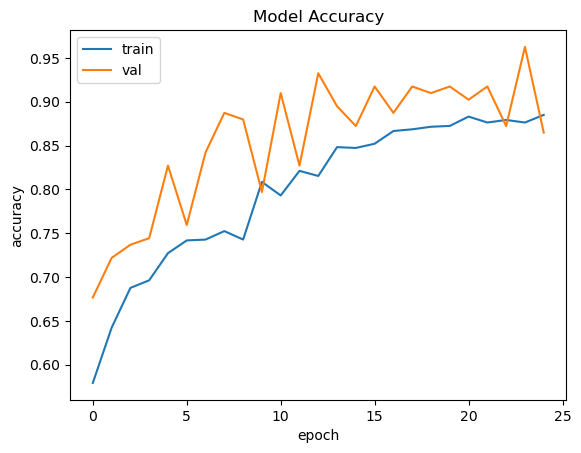

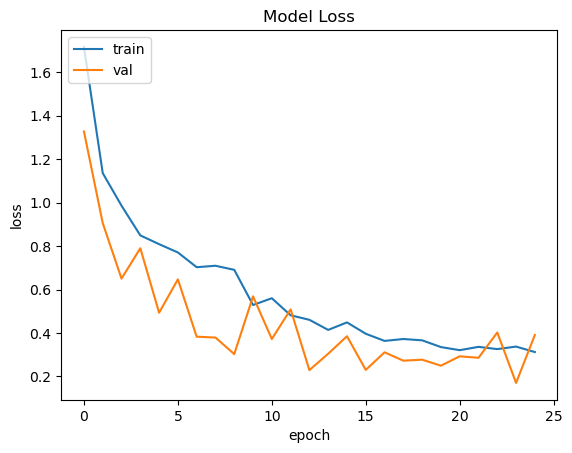

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.8625 - loss: 0.3303
Test set accuracy: 0.8515625


In [6]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

test_loss, test_acc = model.evaluate(test_set_normalized)
print(f"Test set accuracy: {test_acc}")

Adding data augmentation layers helped tackle our model's overfitting! That said, our results are a little unusual; for the most part, the validation accuracy is higher while the validation loss is lower for its training counterparts.

![](https://s3.amazonaws.com/dq-content/781/8.0-m781.png)

It's quite unusual for a model's validation accuracy to be consistently higher than its training accuracy, as typically a model performs better on the data it was trained on (leading to higher training accuracy) compared to unseen data (validation set).

However, there are a few potential reasons for why this might occur:

1.  **Dropout or other regularization techniques during training:** Our model uses dropout layers during training, which randomly "turns off" certain neurons in an attempt to prevent overfitting. This means that the model could perform worse on the training data (since it's effectively a reduced version of the model), but better on the validation data (since all neurons are active).
    
2.  **Size and representativeness of the validation set:** If the validation set is small and/or non-representative of the overall distribution, it's possible that the model could just happen to perform well on it by chance. In other words, it's possible that the model has learned features that are especially good at predicting the validation set, but not necessarily the broader data distribution.
    
3.  **Training set is harder:** It is possible that our training set has more complex or more difficult examples, while our validation set is somewhat easier for our model to predict. This is likely the cause of our unusual results here since augmenting the data may have made the training set more complex compared to the validation set which hasn't been (nor should it be) augmented.
    

We could train the model for more epochs to see how it would perform, and whether it could benefit from more regularization.

In this file, we learned about different regularization techniques that could help prevent a CNN model from overfitting. We covered the following techniques:

-   Early Stopping
-   Dropout
-   Batch Normalization
-   Data Augmentation